<a href="https://colab.research.google.com/github/viratchowdary21/NCBI-disease-corpus-named-entity-recognition-/blob/main/NER_CW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
!pip install sklearn-crfsuite


In [ ]:
!pip install eli5

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-pe2clopq
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-pe2clopq
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=aa0656164768ec619a39fd056447993669ec71b792367fc8e47f4992d3fff248
  Stored in directory: /tmp/pip-ephem-wheel-cache-cf7x1bhp/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
import re
import numpy as np
import pickle

import sys
import os
import pandas as pd

import unicodedata
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Bidirectional, concatenate, Flatten
from keras_contrib.layers import CRF
from keras_contrib.metrics import crf_accuracy
from keras_contrib.losses import crf_loss
from keras.utils import to_categorical
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#Modeling
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import scipy.stats
import sys
import eli5


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

## Read the dataset

In [ ]:
DATA_PATH = '../data/'

train_file = '/content/drive/MyDrive/NCBItrainset_corpus/NCBItrainset_corpus.txt'
test_file = '/content/drive/MyDrive/NCBItrainset_corpus/NCBItestset_corpus.txt'
num_words = 0
with open(train_file, 'r') as fp:
    train_dataset = fp.readlines()
    for line in train_dataset:
      words = line.split()
      num_words += len(words)
print("Number of words:")
print(num_words)

with open(test_file, 'r') as fp:
    test_dataset = fp.readlines()

print('Train texts: %d' % len(train_dataset))
print('Test texts: %d' % len(test_dataset))

Number of words:
148721
Train texts: 6924
Test texts: 1259


In [ ]:
id_test = []
for i in range(len(train_dataset)):
     id_test.append(train_dataset[i].strip().split('\t'))

for i in range(len(test_dataset)):
     id_test.append(test_dataset[i].strip().split('\t'))

In [ ]:
res = [ele for ele in id_test if ele != ['']]

In [ ]:
df = pd.DataFrame(res, columns=['id', 'start', 'end', 'entity', 'label', 'D_id'])

In [ ]:
df.head(5)

,id,start,end,entity,label,D_id
0,10192393|t|A common human skin tumour is caused by activating mutations in beta-catenin.,None,None,None,None,None
1,"10192393|a|WNT signalling orchestrates a number of developmental programs. In response to this stimulus, cytoplasmic beta-catenin (encoded by CTNNB1) is stabilized, enabling downstream transcriptional activation by members of the LEF/TCF family. One of the target genes for beta-catenin/TCF encodes c-MYC, explaining why constitutive activation of the WNT pathway can lead to cancer, particularly in the colon. Most colon cancers arise from mutations in the gene encoding adenomatous polyposis coli (APC), a protein required for ubiquitin-mediated degradation of beta-catenin, but a small percentage of colon and some other cancers harbour beta-catenin-stabilizing mutations. Recently, we discovered that transgenic mice expressing an activated beta-catenin are predisposed to developing skin tumours resembling pilomatricomas. Given that the skin of these adult mice also exhibits signs of de novo hair-follicle morphogenesis, we wondered whether human pilomatricomas might originate from hair m...",None,None,None,None,None
2,10192393,15,26,skin tumour,DiseaseClass,D012878
3,10192393,443,449,cancer,DiseaseClass,D009369
4,10192393,483,496,colon cancers,DiseaseClass,D003110


In [ ]:
df1 = df.loc[df['start'].isnull()]

In [ ]:
df1

,id,start,end,entity,label,D_id
0,10192393|t|A common human skin tumour is caused by activating mutations in beta-catenin.,None,None,None,None,None
1,"10192393|a|WNT signalling orchestrates a number of developmental programs. In response to this stimulus, cytoplasmic beta-catenin (encoded by CTNNB1) is stabilized, enabling downstream transcriptional activation by members of the LEF/TCF family. One of the target genes for beta-catenin/TCF encodes c-MYC, explaining why constitutive activation of the WNT pathway can lead to cancer, particularly in the colon. Most colon cancers arise from mutations in the gene encoding adenomatous polyposis coli (APC), a protein required for ubiquitin-mediated degradation of beta-catenin, but a small percentage of colon and some other cancers harbour beta-catenin-stabilizing mutations. Recently, we discovered that transgenic mice expressing an activated beta-catenin are predisposed to developing skin tumours resembling pilomatricomas. Given that the skin of these adult mice also exhibits signs of de novo hair-follicle morphogenesis, we wondered whether human pilomatricomas might originate from hair m...",None,None,None,None,None
16,10194428|t|HFE mutations analysis in 711 hemochromatosis probands: evidence for S65C implication in mild form of hemochromatosis.,None,None,None,None,None
17,"10194428|a|Hereditary hemochromatosis (HH) is a common autosomal recessive genetic disorder of iron metabolism. The HFE candidate gene encoding an HLA class I-like protein involved in HH was identified in 1996. Two missense mutations have been described C282Y, accounting for 80% to 90% of HH chromosomes, and H63D, which is associated with a milder form of the disease representing 40% to 70% of non-C282Y HH chromosomes. We report here on the analysis of C282Y, H63D, and the 193A-- > T substitution leading to the S65C missense substitution in a large series of probands and controls. The results confirm that the C282Y substitution was the main mutation involved in hemochromatosis, accounting for 85% of carrier chromosomes, whereas the H63D substitution represented 39% of the HH chromosomes that did not carry the C282Y mutation. In addition, our screening showed that the S65C substitution was significantly enriched in probands with at least one chromosome without an assigned mutation....",None,None,None,None,None
31,10196379|t|Germline BRCA1 alterations in a population-based series of ovarian cancer cases.,None,None,None,None,None
...,...,...,...,...,...,...
7466,"9465301|a|The UBE3A gene encodes the E6-AP ubiquitin-protein ligase and has recently been shown to be mutated in Angelman syndrome patients who lack 15q11-q13 deletions or chromosome 15 paternal uniparental disomy. Previous UBE3A cDNA analysis has shown a coding region of approximately 2. 6 kb and a 3-untranslated region (UTR) of < 50 bp, whereas Northern analysis has indicated mRNA sizes of 5-8 kb. We have analyzed additional cDNA clones and provide evidence for an additional 0. 5 kb of 5-UTR and > 2 kb of 3-UTR. We have established the genomic organization of UBE3A and the sequence of intron-exon borders. We have also mapped two highly homologous processed pseudogenes, UBE3AP1 and UBE3AP2, to chromosomes 2 and 21, respectively, and determined their genomic organization. These results will form the basis for studies of mutation and imprinting of UBE3A.",None,None,None,None,None
7469,9949197|t|Distribution of emerin and lamins in the heart and implications for Emery-Dreifuss muscular dystrophy.,None,None,None,None,None
7470,"9949197|a|Emerin is a nuclear membrane protein which is missing or defective in Emery-Dreifuss muscular dystrophy (EDMD). It is one member of a family of lamina-associated proteins which includes LAP1, LAP2 and lamin B receptor (LBR). A panel of 16 monoclonal antibodies (mAbs) has been mapped to six specific sites throughout the emerin molecule using phage-displayed peptide libraries and has been used to localize emerin in human and rabb

In [ ]:
df2 = df1.drop(['start', 'end', 'entity', 'label', 'D_id'], axis=1)

In [ ]:
df2.head()

,id
0,10192393|t|A common human skin tumour is caused by activating mutations in beta-catenin.
1,"10192393|a|WNT signalling orchestrates a number of developmental programs. In response to this stimulus, cytoplasmic beta-catenin (encoded by CTNNB1) is stabilized, enabling downstream transcriptional activation by members of the LEF/TCF family. One of the target genes for beta-catenin/TCF encodes c-MYC, explaining why constitutive activation of the WNT pathway can lead to cancer, particularly in the colon. Most colon cancers arise from mutations in the gene encoding adenomatous polyposis coli (APC), a protein required for ubiquitin-mediated degradation of beta-catenin, but a small percentage of colon and some other cancers harbour beta-catenin-stabilizing mutations. Recently, we discovered that transgenic mice expressing an activated beta-catenin are predisposed to developing skin tumours resembling pilomatricomas. Given that the skin of these adult mice also exhibits signs of de novo hair-follicle morphogenesis, we wondered whether human pilomatricomas might originate from hair m..."
16,10194428|t|HFE mutations analysis in 711 hemochromatosis probands: evidence for S65C implication in mild form of hemochromatosis.
17,"10194428|a|Hereditary hemochromatosis (HH) is a common autosomal recessive genetic disorder of iron metabolism. The HFE candidate gene encoding an HLA class I-like protein involved in HH was identified in 1996. Two missense mutations have been described C282Y, accounting for 80% to 90% of HH chromosomes, and H63D, which is associated with a milder form of the disease representing 40% to 70% of non-C282Y HH chromosomes. We report here on the analysis of C282Y, H63D, and the 193A-- > T substitution leading to the S65C missense substitution in a large series of probands and controls. The results confirm that the C282Y substitution was the main mutation involved in hemochromatosis, accounting for 85% of carrier chromosomes, whereas the H63D substitution represented 39% of the HH chromosomes that did not carry the C282Y mutation. In addition, our screening showed that the S65C substitution was significantly enriched in probands with at least one chromosome without an assigned mutation...."
31,10196379|t|Germline BRCA1 alterations in a population-based series of ovarian cancer cases.


In [ ]:
df3 = df2.iloc[1:-1:2, [0]]

In [ ]:
col2 = []
for i in df3.id.to_list():
  col2.append(i[:8].strip('|a'))

df3['id1'] = col2  

In [ ]:
df3 = df3.rename(columns={'id': 'abstract', 'id1':'id'})

df3.head()

,abstract,id
1,"10192393|a|WNT signalling orchestrates a number of developmental programs. In response to this stimulus, cytoplasmic beta-catenin (encoded by CTNNB1) is stabilized, enabling downstream transcriptional activation by members of the LEF/TCF family. One of the target genes for beta-catenin/TCF encodes c-MYC, explaining why constitutive activation of the WNT pathway can lead to cancer, particularly in the colon. Most colon cancers arise from mutations in the gene encoding adenomatous polyposis coli (APC), a protein required for ubiquitin-mediated degradation of beta-catenin, but a small percentage of colon and some other cancers harbour beta-catenin-stabilizing mutations. Recently, we discovered that transgenic mice expressing an activated beta-catenin are predisposed to developing skin tumours resembling pilomatricomas. Given that the skin of these adult mice also exhibits signs of de novo hair-follicle morphogenesis, we wondered whether human pilomatricomas might originate from hair m...",10192393
17,"10194428|a|Hereditary hemochromatosis (HH) is a common autosomal recessive genetic disorder of iron metabolism. The HFE candidate gene encoding an HLA class I-like protein involved in HH was identified in 1996. Two missense mutations have been described C282Y, accounting for 80% to 90% of HH chromosomes, and H63D, which is associated with a milder form of the disease representing 40% to 70% of non-C282Y HH chromosomes. We report here on the analysis of C282Y, H63D, and the 193A-- > T substitution leading to the S65C missense substitution in a large series of probands and controls. The results confirm that the C282Y substitution was the main mutation involved in hemochromatosis, accounting for 85% of carrier chromosomes, whereas the H63D substitution represented 39% of the HH chromosomes that did not carry the C282Y mutation. In addition, our screening showed that the S65C substitution was significantly enriched in probands with at least one chromosome without an assigned mutation....",10194428
32,"10196379|a|The objective of this study was to provide more accurate frequency estimates of breast cancer susceptibility gene 1 (BRCA1) germline alterations in the ovarian cancer population. To achieve this, we determined the prevalence of BRCA1 alterations in a population-based series of consecutive ovarian cancer cases. This is the first population-based ovarian cancer study reporting BRCA1 alterations derived from a comprehensive screen of the entire coding region. One hundred and seven ovarian cancer cases were analyzed for BRCA1 alterations using the RNase mismatch cleavage assay followed by direct sequencing. Two truncating mutations, 962del4 and 3600del11, were identified. Both patients had a family history of breast or ovarian cancer. Several novel as well as previously reported uncharacterized variants were also identified, some of which were associated with a family history of cancer. The frequency distribution of common polymorphisms was determined in the 91 Caucasian can...",10196379
46,"10021369|a|The adenomatous polyposis coli (APC) tumour-suppressor protein controls the Wnt signalling pathway by forming a complex with glycogen synthase kinase 3beta (GSK-3beta), axin/conductin and betacatenin. Complex formation induces the rapid degradation of betacatenin. In colon carcinoma cells, loss of APC leads to the accumulation of betacatenin in the nucleus, where it binds to and activates the Tcf-4 transcription factor (reviewed in [1] [2]). Here, we report the identification and genomic structure of APC homologues. Mammalian APC2, which closely resembles APC in overall domain structure, was functionally analyzed and shown to contain two SAMP domains, both of which are required for binding to conductin. Like APC, APC2 regulates the formation of active betacatenin-Tcf complexes, as demonstrated using transient transcriptional activation assays in APC -/- colon carcinoma cells. Human APC2 maps to chromosome 19p13. 3. APC

In [ ]:
df4 = df2.iloc[0:-1:2, [0]]


In [ ]:
df4.head()

,id
0,10192393|t|A common human skin tumour is caused by activating mutations in beta-catenin.
16,10194428|t|HFE mutations analysis in 711 hemochromatosis probands: evidence for S65C implication in mild form of hemochromatosis.
31,10196379|t|Germline BRCA1 alterations in a population-based series of ovarian cancer cases.
45,"10021369|t|Identification of APC2, a homologue of the adenomatous polyposis coli tumour suppressor."
52,100562|t|Familial deficiency of the seventh component of complement associated with recurrent bacteremic infections due to Neisseria.


In [ ]:
col1 = []
for i in df4.id.to_list():
  col1.append(i[:8].strip('|t'))

df4['id1'] = col1  

In [ ]:
df4 = df4.rename(columns={'id': 'title', 'id1': 'id'})
df4.head()

,title,id
0,10192393|t|A common human skin tumour is caused by activating mutations in beta-catenin.,10192393
16,10194428|t|HFE mutations analysis in 711 hemochromatosis probands: evidence for S65C implication in mild form of hemochromatosis.,10194428
31,10196379|t|Germline BRCA1 alterations in a population-based series of ovarian cancer cases.,10196379
45,"10021369|t|Identification of APC2, a homologue of the adenomatous polyposis coli tumour suppressor.",10021369
52,100562|t|Familial deficiency of the seventh component of complement associated with recurrent bacteremic infections due to Neisseria.,100562


In [ ]:
df5 = pd.merge(df4, df3, on='id')



In [ ]:
df = pd.merge(df5, df, on='id', left_index=True)


In [ ]:
df.head(1)

,title,id,abstract,start,end,entity,label,D_id
2,10192393|t|A common human skin tumour is caused by activating mutations in beta-catenin.,10192393,"10192393|a|WNT signalling orchestrates a number of developmental programs. In response to this stimulus, cytoplasmic beta-catenin (encoded by CTNNB1) is stabilized, enabling downstream transcriptional activation by members of the LEF/TCF family. One of the target genes for beta-catenin/TCF encodes c-MYC, explaining why constitutive activation of the WNT pathway can lead to cancer, particularly in the colon. Most colon cancers arise from mutations in the gene encoding adenomatous polyposis coli (APC), a protein required for ubiquitin-mediated degradation of beta-catenin, but a small percentage of colon and some other cancers harbour beta-catenin-stabilizing mutations. Recently, we discovered that transgenic mice expressing an activated beta-catenin are predisposed to developing skin tumours resembling pilomatricomas. Given that the skin of these adult mice also exhibits signs of de novo hair-follicle morphogenesis, we wondered whether human pilomatricomas might originate from hair m...",15,26,skin tumour,DiseaseClass,D012878


In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                 if unicodedata.category(c) != 'Mn')


def Text_cleaning(w):
  w = unicode_to_ascii(w.lower().strip())

  w = re.sub(r"([?.!,¿,<,>])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r'["|a|"]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  return w


In [ ]:
text = []
cleaned_title = []
text = df['abstract'].to_list()
for i in range(len(text)):
  cleaned_title.append(Text_cleaning(text[i]))

In [ ]:
df['abstract'] = cleaned_title

In [ ]:
df.head(10)

,title,id,abstract,start,end,entity,label,D_id
2,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,15,26,skin tumour,DiseaseClass,D012878
3,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,443,449,cancer,DiseaseClass,D009369
4,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,483,496,colon cancers,DiseaseClass,D003110
5,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,539,565,adenomatous polyposis coli,SpecificDisease,D011125
6,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,567,570,APC,SpecificDisease,D011125
7,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,670,698,colon and some other cancers,CompositeMention,D003110|D009369
8,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,855,867,skin tumours,DiseaseClass,D012878
9,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,879,893,pilomatricomas,SpecificDisease,D018296
10,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,1021,1035,pilomatricomas,SpecificDisease,D018296
11,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,1210,1221,skin tumour,DiseaseClass,D012878


# creating a sentence to word dataset with POS tags

In [ ]:
nlp = spacy.load('en_core_web_sm')

doc = nlp("identification of apc homologue of the categorymodifieradenomatous polyposis coli tumourcategory suppressor the categorymodifieradenomatous polyposis coli apc tumourcategorysuppressor protein controls the wnt signalling pathway by forming complex with glycogen synthase kinase beta gsk beta axin conductin and betacatenin complex formation induces the rapid degradation of betacatenin in categorymodifiercolon carcinomacategory cells loss of apc leads to the accumulation of betacatenin in the nucleus where it binds to and activates the tcf transcription factor reviewed in here we report the identification and genomic structure of apc homologues mammalian apc which closely resembles apc in overall domain structure was functionally analyzed and shown to contain two samp domains both of which are required for binding to conductin like apc apc regulates the formation of active betacatenintcf complexes as demonstrated using transient transcriptional activation assays in apc categorymodifiercolon carcinomacategory cells human apc maps to chromosome apc and apc may therefore have comparable functions in development and categoryspecificdiseasecancercategory")

for tok in doc:
    print(tok.text, "...", tok.dep_)

identification ... nsubj
of ... prep
apc ... compound
homologue ... pobj
of ... prep
the ... det
categorymodifieradenomatous ... amod
polyposis ... compound
coli ... compound
tumourcategory ... compound
suppressor ... pobj
the ... det
categorymodifieradenomatous ... amod
polyposis ... compound
coli ... compound
apc ... compound
tumourcategorysuppressor ... compound
protein ... nsubj
controls ... ROOT
the ... det
wnt ... compound
signalling ... compound
pathway ... dobj
by ... prep
forming ... pcomp
complex ... dobj
with ... prep
glycogen ... compound
synthase ... compound
kinase ... compound
beta ... compound
gsk ... compound
beta ... compound
axin ... compound
conductin ... pobj
and ... cc
betacatenin ... amod
complex ... amod
formation ... nsubj
induces ... conj
the ... det
rapid ... amod
degradation ... dobj
of ... prep
betacatenin ... pobj
in ... prep
categorymodifiercolon ... compound
carcinomacategory ... compound
cells ... compound
loss ... pobj
of ... prep
apc ... pobj
leads ..

# model

here we have used spacy pre-trained model to classify the parts of speech and text category labels. we build two dataframes based on them and further we performed CRF model on this pre-trained model.

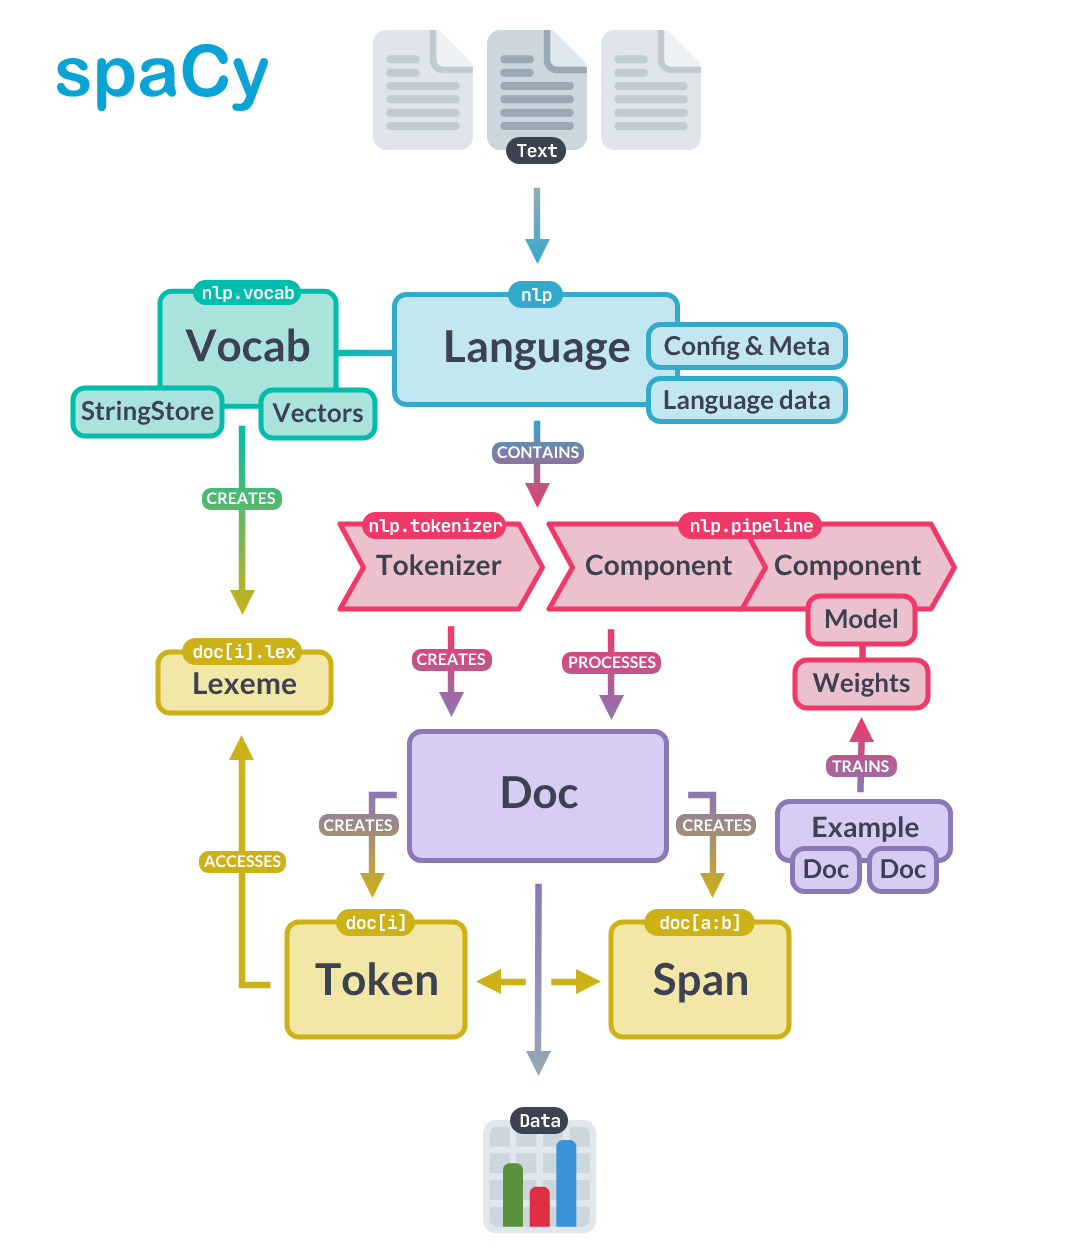

In [ ]:
import spacy
from spacy import displacy
sp = spacy.load('en_core_web_sm')

In [ ]:
doc2 = sp('identification of apc , a homologue of the category modifier adenomatous polyposis coli tumour category suppressor . the category modifier adenomatous polyposis coli apc tumour category suppressor protein controls the wnt signalling pathway by forming a complex with glycogen synthase kinase beta gsk beta , axin conductin and betacatenin . complex formation induces the rapid degradation of betacatenin . ')

In [ ]:
displacy.render(doc2, style="dep", jupyter=True)

In [ ]:
displacy.render(doc2, style="ent", jupyter=True)


In [ ]:
spacy_sen = []
for i in df.abstract.unique():
  spacy_sen.append(sp(i))
  

In [ ]:
no_of_words_spacy = 0
for sent in spacy_sen:
  no_of_words_spacy += len(sent)

print(no_of_words_spacy)


141432


In [ ]:
word_text = 0
for sent in spacy_sen:
  for word in sent:
    word_text += len(word.text)
    # print(f'{word.text:{10}} {word.pos_:{10}} {word.tag_:{10}} {spacy.explain(word.tag_)}')


In [ ]:
word_text

514648

In [ ]:
# df10 = pd.DataFrame({'id': 1,'word': word.text, 'position': word.pos_, ''})
df123 = {'id':[],'word': [],'position': [],'tag': [],'explanation': []}
pos_df = pd.DataFrame (df123)
i=0
for sent in spacy_sen[:5]:
  for word in sent:
	  pos_df = pos_df .append( {'id':i,'word': word.text,'position': word.pos_ ,
                             'tag': word.tag_ ,'explantion': spacy.explain(word.tag_)},ignore_index=True)
  i = i+1

In [ ]:
pos_df.head(5)

,id,word,position,tag,explanation,explantion
0,0.0,wnt,PROPN,NNP,NaN,"noun, proper singular"
1,0.0,sign,NOUN,NN,NaN,"noun, singular or mass"
2,0.0,lling,VERB,VBG,NaN,"verb, gerund or present participle"
3,0.0,orchestr,NOUN,NN,NaN,"noun, singular or mass"
4,0.0,tes,NOUN,NN,NaN,"noun, singular or mass"


In [ ]:
pos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1380 non-null   float64
 1   word         1380 non-null   object 
 2   position     1380 non-null   object 
 3   tag          1380 non-null   object 
 4   explanation  0 non-null      float64
 5   explantion   1380 non-null   object 
dtypes: float64(2), object(4)
memory usage: 64.8+ KB


In [ ]:
pos_df.shape

(1380, 6)

In [ ]:
pos_df.isnull().sum()

id                0
word              0
position          0
tag               0
explanation    1380
explantion        0
dtype: int64

# dataframe2

In [ ]:
for sent in spacy_sen:
  for word in sent.ents:
    print(f'{word.text:{10}} {word.start_char:{10}} {word.end_char:{10}} {word.label_:{10}}')

Streaming output truncated to the last 5000 lines.
nd                819        821 GPE       
only two          822        830 CARDINAL  
jewish           1053       1059 NORP      
bre st nd        1108       1117 PERSON    
brc              1149       1152 GPE       
two                 0          3 CARDINAL  
hnsh              116        120 GPE       
g pd w yne        225        235 PERSON    
nd                258        260 GPE       
g pd huron        316        326 PERSON    
medic l observ tion        338        357 ORG       
europe            484        490 LOC       
north meric n         22         35 FAC       
y s                38         41 PRODUCT   
progr m            81         88 PERSON    
frequency mong        107        121 PERSON    
jewish            124        130 NORP      
tes b             226        231 PERSON    
nd                320        322 GPE       
jews              352        356 NORP      
jews              422        426 NORP      
polish   

In [ ]:
df223 = {'id':[],'word': [],'start': [],'end': [],'label': []}
ent_df = pd.DataFrame (df223)
i=0
for sent in spacy_sen:
  for word in sent.ents:
	  ent_df = ent_df .append( {'id':i,'word': word.text,'start': word.start_char ,
                             'end': word.end_char ,'label': word.label_},ignore_index=True)
  i = i+1

In [ ]:
ent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10509 entries, 0 to 10508
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      10509 non-null  float64
 1   word    10509 non-null  object 
 2   start   10509 non-null  float64
 3   end     10509 non-null  float64
 4   label   10509 non-null  object 
dtypes: float64(3), object(2)
memory usage: 410.6+ KB


In [ ]:
ent_df.shape

(10509, 5)

In [ ]:
ent_df.isnull().sum()

id       0
word     0
start    0
end      0
label    0
dtype: int64

In [ ]:

ent_df.head(10)

,id,word,start,end,label
0,0.0,wnt sign lling orchestr,0.0,23.0,PERSON
1,0.0,ctnnb,129.0,134.0,ORG
2,0.0,downstre m tr nscription,160.0,184.0,PERSON
3,0.0,tcf f mily,219.0,229.0,GPE
4,0.0,one,232.0,235.0,CARDINAL
5,0.0,tcf encodes c myc,272.0,289.0,PERSON
6,0.0,the wnt p thw y c n le,333.0,355.0,ORG
7,0.0,ted degr,525.0,533.0,PERSON
8,0.0,ge,576.0,578.0,PERSON
9,0.0,colon nd,582.0,590.0,ORG


In [ ]:
len(pos_df.word.unique()),len(pos_df.position.unique()), len(pos_df.tag.unique())

(430, 16, 32)

In [ ]:
pos_df = pos_df[pos_df.id.values <= 4]

In [ ]:
len(df['abstract'].to_list()[0])

1661

In [ ]:
pos_df.shape

(1380, 6)

In [ ]:
class getsentence(object):
    
    def __init__(self, pos_df):
        self.n_sent = 1
        self.data = pos_df
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["position"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = getsentence(pos_df)
sentences = getter.sentences
#This is how a sentence will look like. 
print(sentences[0])


[('wnt', 'PROPN', 'NNP'), ('sign', 'NOUN', 'NN'), ('lling', 'VERB', 'VBG'), ('orchestr', 'NOUN', 'NN'), ('tes', 'NOUN', 'NN'), ('number', 'NOUN', 'NN'), ('of', 'ADP', 'IN'), ('development', 'PROPN', 'NNP'), ('l', 'PROPN', 'NNP'), ('progr', 'PROPN', 'NNP'), ('ms', 'PROPN', 'NNP'), ('.', 'PROPN', 'NNP'), ('in', 'ADP', 'IN'), ('response', 'NOUN', 'NN'), ('to', 'ADP', 'IN'), ('this', 'DET', 'DT'), ('stimulus', 'NOUN', 'NN'), (',', 'PUNCT', ','), ('cytopl', 'PROPN', 'NNP'), ('smic', 'PROPN', 'NNP'), ('bet', 'PROPN', 'NNP'), ('c', 'PROPN', 'NNP'), ('tenin', 'NOUN', 'NN'), ('encoded', 'VERB', 'VBN'), ('by', 'ADP', 'IN'), ('ctnnb', 'PROPN', 'NNP'), ('is', 'AUX', 'VBZ'), ('st', 'PROPN', 'NNP'), ('bilized', 'VERB', 'VBN'), (',', 'PUNCT', ','), ('en', 'ADP', 'IN'), ('bling', 'VERB', 'VBG'), ('downstre', 'PROPN', 'NNP'), ('m', 'PROPN', 'NNP'), ('tr', 'ADP', 'IN'), ('nscription', 'PROPN', 'NNP'), ('l', 'PROPN', 'NNP'), ('ctiv', 'PROPN', 'NNP'), ('tion', 'NOUN', 'NN'), ('by', 'ADP', 'IN'), ('members

In [ ]:
#Lets find the number of words in the dataset
words = list(set(pos_df["word"].values))
n_words = len(words)
print(n_words)

430


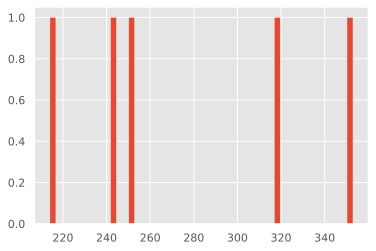

In [ ]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
#Lets find out the longest sentence length in the dataset
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Maximum sentence length: 353


In [ ]:
pos_df.tag.unique()

array(['NNP', 'NN', 'VBG', 'IN', 'DT', ',', 'VBN', 'VBZ', 'NNS', 'XX',
       'RB', '.', 'CD', 'NNPS', 'WRB', 'JJ', 'LS', 'JJS', 'VBP', 'VB',
       'CC', 'MD', 'PRP', 'VBD', 'POS', 'PRP$', 'WDT', 'FW', 'TO', 'JJR',
       'UH', 'WP'], dtype=object)

In [ ]:
pos_df.loc[pos_df['tag'] == 'NN', 'word'].head()


1         sign
3     orchestr
4          tes
5       number
13    response
Name: word, dtype: object

In [ ]:
pos_df.loc[pos_df['tag'] == 'NNP', 'word'].head()


0             wnt
7     development
8               l
9           progr
10             ms
Name: word, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


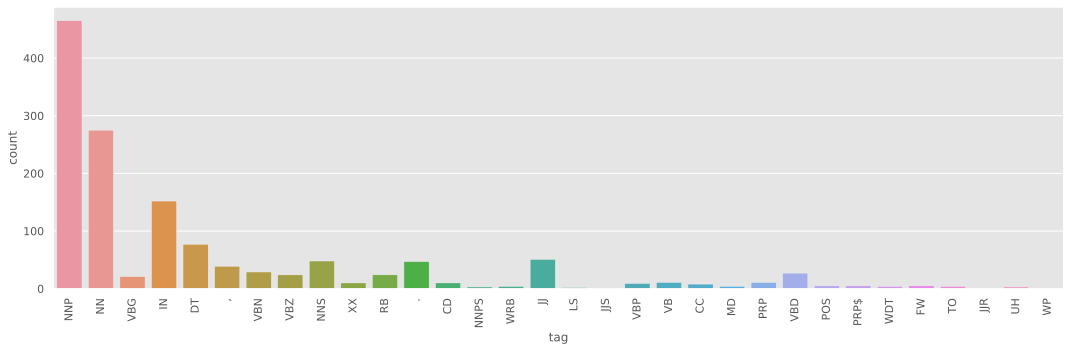

In [ ]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('tag', data=pos_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


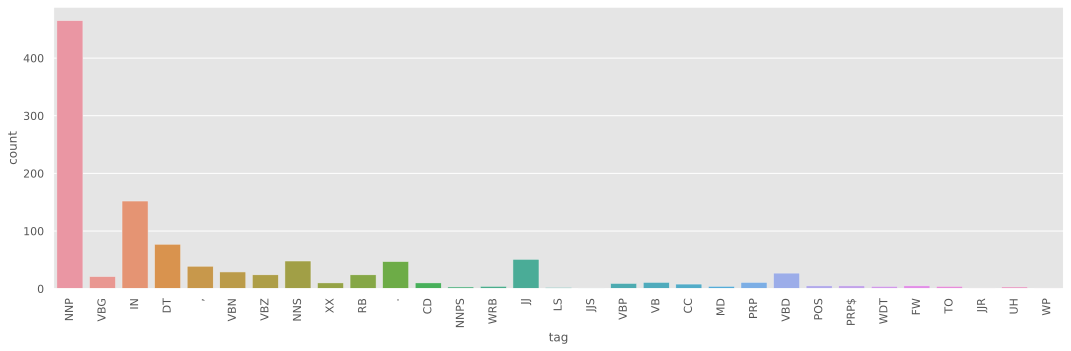

In [ ]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('tag', data=pos_df.loc[pos_df['tag'] != 'NN'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


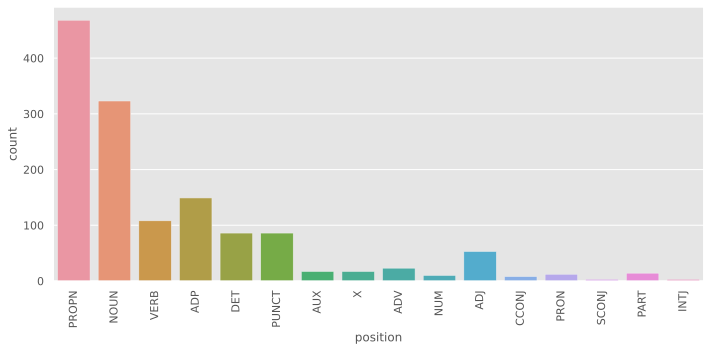

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.countplot('position', data=pos_df, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [ ]:
#Simple feature map to feed arrays into the classifier. 
def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(),  word.isalpha()])


In [ ]:
#We divide the dataset into train and test sets
words = [feature_map(w) for w in pos_df["word"].values.tolist()]
tags = pos_df["tag"].values.tolist()


In [ ]:
#Lets see how the input array looks like
print(words[:5])


[array([0, 1, 0, 3, 0, 1]), array([0, 1, 0, 4, 0, 1]), array([0, 1, 0, 5, 0, 1]), array([0, 1, 0, 8, 0, 1]), array([0, 1, 0, 3, 0, 1])]


In [ ]:
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),X=words, y=tags, cv=5)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


**CRF model (classification report)**

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_pred=pred, y_true=tags)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           ,       0.00      0.00      0.00        39
           .       0.54      1.00      0.70        47
          CC       0.00      0.00      0.00         8
          CD       0.00      0.00      0.00        10
          DT       0.00      0.00      0.00        77
          FW       0.00      0.00      0.00         5
          IN       0.45      0.82      0.58       152
          JJ       0.00      0.00      0.00        51
         JJR       0.00      0.00      0.00         1
         JJS       0.00      0.00      0.00         1
          LS       0.00      0.00      0.00         2
          MD       0.00      0.00      0.00         4
          NN       0.34      0.54      0.42       275
         NNP       0.46      0.57      0.51       465
        NNPS       0.00      0.00      0.00         3
         NNS       0.00      0.00      0.00        48
         POS       0.00      0.00      0.00         5
         PRP       0.00    

In [ ]:
from itertools import chain
def get_dict_map(pos_df, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(pos_df['word'].to_list()))
    else:
        vocab = list(set(pos_df['tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok
token2idx, idx2token = get_dict_map(pos_df, 'token')
tag2idx, idx2tag = get_dict_map(pos_df, 'tag')

In [ ]:
pos_df['Word_idx'] = pos_df['word'].map(token2idx)
pos_df['Tag_idx'] = pos_df['tag'].map(tag2idx)
data_fillna = pos_df.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(
['id'],as_index=False
)['word', 'position', 'tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


In [ ]:
len(list(set(pos_df['word'].to_list())))

430

In [ ]:
len(list(set(pos_df['tag'].to_list())))

32

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
bag_of_words = vectorizer.fit_transform(df['entity'].to_list())

In [ ]:
vectorizer1 = TfidfVectorizer()
bag_of_words1 = vectorizer1.fit_transform(df['label'].to_list())

In [ ]:
list(vectorizer1.vocabulary_.values())


[1, 3, 0, 2]

In [ ]:
print("Sparsity of bag_of_words:",
      len(bag_of_words.data)/(bag_of_words.shape[0]*bag_of_words.shape[1])*100)

Sparsity of bag_of_words: 0.14570515285522015


In [ ]:
list(vectorizer.vocabulary_.keys())

['skin',
 'tumour',
 'cancer',
 'colon',
 'cancers',
 'adenomatous',
 'polyposis',
 'coli',
 'apc',
 'and',
 'some',
 'other',
 'tumours',
 'pilomatricomas',
 'hemochromatosis',
 'hereditary',
 'hh',
 'autosomal',
 'recessive',
 'genetic',
 'disorder',
 'ovarian',
 'breast',
 'or',
 'carcinoma',
 'familial',
 'deficiency',
 'of',
 'the',
 'seventh',
 'component',
 'complement',
 'bacteremic',
 'infections',
 'due',
 'to',
 'neisseria',
 'disseminated',
 'gonococcal',
 'infection',
 'meningococcal',
 'meningitis',
 'arthritis',
 'absence',
 'functional',
 'c7',
 'complete',
 'oromandibular',
 'dystonia',
 'dystonic',
 'dopa',
 'responsive',
 'disease',
 'hemochromatotic',
 'mediterranean',
 'fever',
 'fmf',
 'serositis',
 'synovitis',
 'autoimmune',
 'lymphoproliferative',
 'syndrome',
 'alps',
 'lymphocyte',
 'homeostasis',
 'immunological',
 'tolerance',
 'linked',
 'adrenoleukodystrophy',
 'ald',
 'inherited',
 'neurologic',
 'dysfunction',
 'adrenal',
 'insufficiency',
 'childhood',

In [ ]:
len(list(vectorizer.vocabulary_.keys()))

1344

In [ ]:
print(bag_of_words.shape, len(vectorizer.vocabulary_))


(5201, 1344) 1344


In [ ]:
embeds = []
zeros_embed = 100*[0]
for key,val in sorted(vectorizer.vocabulary_.items(), key = lambda kv:(kv[1], kv[0])):
# vectorizer.vocabulary_.keys():
    if key in embeddings_dictionary:
        embeds.append(embeddings_dictionary[key])
    else:
        embeds.append(zeros_embed)
    if val%1000 == 0:
        print(val,key)


0 100
1000 oxidoreductase


In [ ]:
import scipy.sparse as sparse
my_embeddings = sparse.csr_matrix(embeds)

In [ ]:
doc_embeds = bag_of_words.dot(my_embeddings)

In [ ]:
doc_embeds.shape

(5201, 100)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve

In [ ]:
doc_embeds[0]

<1x100 sparse matrix of type '<class 'numpy.float64'>'
	with 100 stored elements in Compressed Sparse Row format>

converting the label values to to categorical neumarical values

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
categorical_features = df.label.tolist()
df['label'] = encoder.fit_transform(df['label'])


In [ ]:
df.head(5)

,title,id,abstract,start,end,entity,label,D_id
2,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,15,26,skin tumour,1,D012878
3,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,443,449,cancer,1,D009369
4,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,483,496,colon cancers,1,D003110
5,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,539,565,adenomatous polyposis coli,3,D011125
6,10192393|t|A common human skin tumour is cause...,10192393,wnt sign lling orchestr tes number of developm...,567,570,APC,3,D011125


In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df['entity'],
                                                        df['label'], test_size=0.20, random_state=42)


# Multi Classification using Bi-LSTM's for labeling


In [ ]:
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras import preprocessing
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization

In [ ]:
tokenizer1 = Tokenizer(num_words=5000)
tokenizer1.fit_on_texts(X1_train.values)

X1_train1 = tokenizer1.texts_to_sequences(X1_train)
X1_test1 = tokenizer1.texts_to_sequences(X1_test)

vocab_size2 = len(tokenizer1.word_index) + 1


X1_train1 = pad_sequences(X1_train1, padding='post')
X1_test1 = pad_sequences(X1_test1, padding='post')

In [ ]:
len(df['label'].unique())

4

In [ ]:
y1_train = to_categorical(y1_train, num_classes = 4, dtype='int')
y1_test = to_categorical(y1_test, num_classes = 4, dtype='int')



In [ ]:
tokenizer1.word_index

{'deficiency': 1,
 'syndrome': 2,
 'cancer': 3,
 'disease': 4,
 'of': 5,
 'dystrophy': 6,
 'breast': 7,
 'ovarian': 8,
 'x': 9,
 'dmd': 10,
 'dm': 11,
 'ald': 12,
 'and': 13,
 'muscular': 14,
 'disorder': 15,
 'apc': 16,
 'linked': 17,
 'the': 18,
 'g6pd': 19,
 'familial': 20,
 'pws': 21,
 'tumor': 22,
 'myotonic': 23,
 'hd': 24,
 'polyposis': 25,
 'tumors': 26,
 'hereditary': 27,
 'was': 28,
 'duchenne': 29,
 'autosomal': 30,
 'adenomatous': 31,
 'recessive': 32,
 'mjd': 33,
 'ataxia': 34,
 'pku': 35,
 'aniridia': 36,
 'cancers': 37,
 'vhl': 38,
 'type': 39,
 'adrenoleukodystrophy': 40,
 'complement': 41,
 'deficient': 42,
 'genetic': 43,
 'fap': 44,
 'colorectal': 45,
 'abnormalities': 46,
 'a': 47,
 'tay': 48,
 'sachs': 49,
 'glucose': 50,
 'prader': 51,
 'willi': 52,
 'dehydrogenase': 53,
 'congenital': 54,
 'phenylketonuria': 55,
 'tsd': 56,
 'fmf': 57,
 'c2': 58,
 'von': 59,
 'lesch': 60,
 'nyhan': 61,
 't': 62,
 'hemochromatosis': 63,
 'dysplasia': 64,
 '6': 65,
 'inherited': 66

In [ ]:
embedding_matrix2 = zeros((vocab_size2, 100))
for word, index in tokenizer1.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix2[index] = embedding_vector

In [ ]:
embedding_matrix2.shape[1]

100

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
model2 = Sequential()

model2.add(
Embedding(input_dim=embedding_matrix2.shape[0],
output_dim=embedding_matrix2.shape[1],
weights=[embedding_matrix2],
trainable=True))
model2.add(Bidirectional(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model2.add(Dropout(0.3))
model2.add(Bidirectional(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model2.add(Dropout(0.3))

model2.add(Bidirectional(LSTM(32,dropout=0.5, recurrent_dropout=0.5)))
# model2.add(SpatialDropout1D(0.3))
model2.add(Dense(32,activation='relu'))
# model2.add(SpatialDropout1D(0.3))
model2.add(Dense(4,activation='softmax'))
model2.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
print(model2.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         126400    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 64)          34048     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 32)               

In [ ]:
import tensorflow as tf 
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
SEED = 42 
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

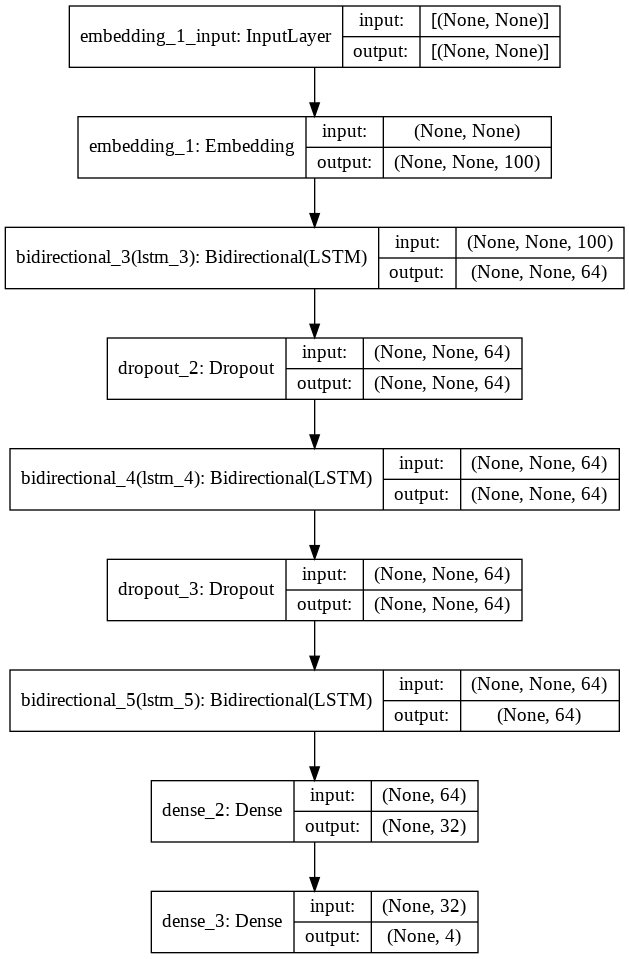

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file='model.png', show_shapes=True)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def ROC_CM(y_train_true, y_train_prob, y_test_true, y_test_prob):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
    Use the best threshold found in train set to classify items in test set.
    '''
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_prob, pos_label =True)
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    y_train = y_train_prob > best_threshold

    cm_train = confusion_matrix(y_train_true, y_train)
    acc_train = accuracy_score(y_train_true, y_train)
    auc_train = roc_auc_score(y_train_true, y_train)

    print('Train Accuracy: %s ' %acc_train)
    print('Train AUC: %s ' %auc_train)
#     print('Train Confusion Matrix:')
#     print(cm_train)

    fig = plt.figure(figsize=(15,13))
    ax = fig.add_subplot(221)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train, best_tpr_train, s = '(%.3f,%.3f)' %(best_fpr_train, best_tpr_train))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f'%auc_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_true, y_test_prob, pos_label =True)

    y_test = y_test_prob > best_threshold

    cm_test = confusion_matrix(y_test_true, y_test)
    acc_test = accuracy_score(y_test_true, y_test)
    auc_test = roc_auc_score(y_test_true, y_test)

    print('Test Accuracy: %s ' %acc_test)
    print('Test AUC: %s ' %auc_test)
#     print('Test Confusion Matrix:')
#     print(cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])

    ax2 = fig.add_subplot(222)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score, tpr_score, s = '(%.3f,%.3f)' %(fpr_score, tpr_score))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f'%auc_test)
    plt.savefig('ROC', dpi = 500)

    df_cm_train = pd.DataFrame(cm_train, index = [i for i in ["True Positive","False Positive"]],
                         columns = [i for i in ["False Negative", "True Negative"]])
    ax3 = fig.add_subplot(223)
    plt.title("Train Confusion Matrix")
    sns.heatmap(df_cm_train, annot=True,fmt="d")
    df_cm_test = pd.DataFrame(cm_test, index = [i for i in ["True Positive","False Positive"]],
                         columns = [i for i in ["False Negative", "True Negative"]])
    ax3 = fig.add_subplot(224)
    
    plt.title("Test Confusion Matrix")
    sns.heatmap(df_cm_test, annot=True,fmt="d")
    
    plt.show()
    
    return best_threshold


In [ ]:
RocAuc = RocAucEvaluation(validation_data=(X1_train1, y1_train), interval=1)


In [ ]:
X1_train1[1]

array([22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [ ]:
y1_train[1]

array([0, 0, 1, 0])

In [ ]:
X1_train1.shape, y1_train.shape

((4160, 11), (4160, 4))

In [ ]:
X1_test1.shape, y1_test.shape


((1041, 11), (1041, 4))

In [ ]:
# model2.fit(pad_sequences(tokenizer.texts_to_sequences(X1_train)),
#           y1_train,batch_size=128,epochs=1)
# validation_data=(pad_sequences(tokenizer.texts_to_sequences(X1_test)),y1_test))

history = model2.fit(X1_train1, y1_train, batch_size=128, epochs=10, callbacks=[RocAuc], verbose=1, validation_split=0.2)


Epoch 1/10
26/26 [==============================] - 12s 143ms/step - loss: 1.2826 - accuracy: 0.4961 - val_loss: 1.0426 - val_accuracy: 0.5781

 ROC-AUC - epoch: 1 - score: 0.492481
Epoch 2/10
26/26 [==============================] - 2s 95ms/step - loss: 1.0093 - accuracy: 0.5846 - val_loss: 0.9298 - val_accuracy: 0.5733

 ROC-AUC - epoch: 2 - score: 0.780321
Epoch 3/10
26/26 [==============================] - 2s 96ms/step - loss: 0.9104 - accuracy: 0.5880 - val_loss: 0.8018 - val_accuracy: 0.6094

 ROC-AUC - epoch: 3 - score: 0.831015
Epoch 4/10
26/26 [==============================] - 2s 95ms/step - loss: 0.8112 - accuracy: 0.6489 - val_loss: 0.7292 - val_accuracy: 0.6526

 ROC-AUC - epoch: 4 - score: 0.863280
Epoch 5/10
26/26 [==============================] - 2s 93ms/step - loss: 0.7332 - accuracy: 0.6760 - val_loss: 0.6875 - val_accuracy: 0.6851

 ROC-AUC - epoch: 5 - score: 0.883846
Epoch 6/10
26/26 [==============================] - 2s 95ms/step - loss: 0.6983 - accuracy: 0.6991

In [ ]:
y_pred = model2.predict(X1_test1, batch_size=1024, verbose=1)


2/2 [==============================] - 1s 24ms/step


# knowledge-graph

In [ ]:
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 1000)
%matplotlib inline

In [ ]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [ ]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [ ]:
entity_pairs = []

for i in tqdm(df["abstract"].unique()):
    entity_pairs.append(get_entities(i))


100%|██████████| 591/591 [00:52<00:00, 11.17it/s]


In [ ]:
entity_pairs[10:20]

[['c c deficiency nd', 'neous v sculitis'],
 ['homeost  sis', 'rious dpd deficiency'],
 ['frequent t iw we', 'signific nt them'],
 ['previously s ch r', 'ccumul tic pob protein'],
 ['only h who', 'four ye r period'],
 ['ffected c n', 'le c rrier'],
 ['th lysis m y', 'such l c ses'],
 ['we', 'intr genic polymorphism'],
 ['tous polyposis gene', 'consistent link ge studies'],
 ['s', 'genetic molecul defect']]

In [ ]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [ ]:
get_relation("John completed the task")


'completed'

In [ ]:
relations = [get_relation(i) for i in tqdm(df['abstract'].unique())]




  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 1/591 [00:00<01:14,  7.97it/s]

  0%|          | 2/591 [00:00<01:11,  8.29it/s]

  1%|          | 3/591 [00:00<01:10,  8.32it/s]

  1%|          | 4/591 [00:00<01:09,  8.46it/s]

  1%|          | 5/591 [00:00<01:08,  8.53it/s]

  1%|          | 7/591 [00:00<01:07,  8.67it/s]

  1%|▏         | 8/591 [00:00<01:07,  8.61it/s]

  2%|▏         | 9/591 [00:01<01:09,  8.39it/s]

  2%|▏         | 10/591 [00:01<01:12,  8.04it/s]

  2%|▏         | 12/591 [00:01<01:07,  8.60it/s]

  2%|▏         | 13/591 [00:01<01:07,  8.58it/s]

  2%|▏         | 14/591 [00:01<01:05,  8.80it/s]

  3%|▎         | 15/591 [00:01<01:08,  8.43it/s]

  3%|▎         | 16/591 [00:01<01:07,  8.47it/s]

  3%|▎         | 17/591 [00:01<01:04,  8.83it/s]

  3%|▎         | 19/591 [00:02<01:01,  9.36it/s]

  3%|▎         | 20/591 [00:02<01:03,  8.97it/s]

  4%|▎         | 21/591 [00:02<01:05,  8.72it/s]

  4%|▎         | 22/591 [00:02<01:07,  8.44it/s]

  4%|▍         

In [ ]:
pd.Series(relations).value_counts()[:50]


is                   35
suggest th           17
provide              16
be                   14
s                     8
suggests th           7
suggest               7
l                     6
support               6
words                 5
conclude th           5
sed                   5
observed              5
expressed             4
dise                  4
ring                  4
tion                  4
suggests              4
give                  4
expl in               4
re                    4
provides              4
were                  3
detected              3
provide further       3
nce of                3
represent             3
ns                    3
ffected               3
cilit te              3
discussed             3
tes                   3
help                  2
is due                2
ccounted for by       2
n                     2
been                  2
observed in           2
function of           2
tion of               2
rrying                2
described       

In [ ]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,lef misregul tion,ir hum ns,s
1,s c substitution,mild hemochrom tosis,is
2,c ncer nd,well popul tion,tions in
3,tr pc m y,ble nd c ncer,functions in
4,ctericid m y,defense g cteremic neisseri infections,nt in
...,...,...,...
586,rge exp nsions,vior m le nd,beh
587,thus l c cdh,inherited c g,ncers
588,common who,common ncestor,rose s postzygotic
589,dmd m results,llelic gene mut tions,nts of


In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

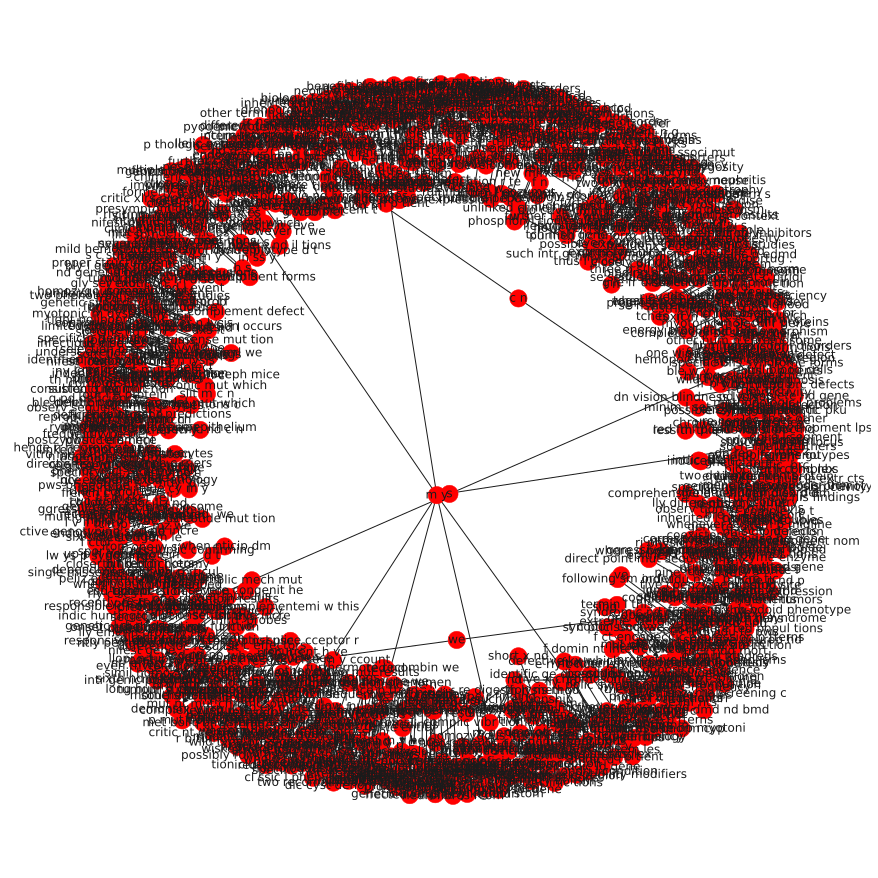

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

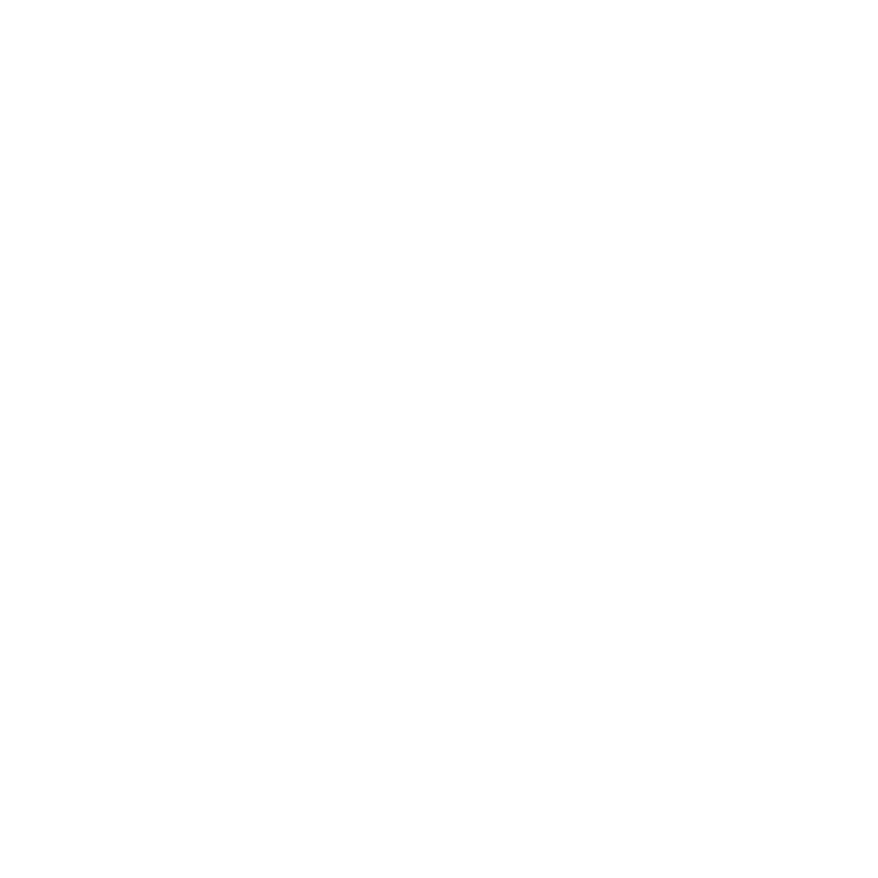

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="tumor"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()
